In [1]:

import os
import sys
import csv
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src.architectures.auto_regressive import SequentialAutoRegressive
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, loss_functions, activations, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'stock_prediction_rnn')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define the feature and target columns
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

In [3]:
shuffle_data = True # Whether to shuffle the data before splitting
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 3e-4 # Learning rate for the optimizer
batch_size = 32 # Number of samples to use for each batch
epochs = 50 # Number of epochs to train the model
seq_len = 24 # Length of the input sequences
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
def load_data(file_path: str) -> list[dict]:
    """
    Load data from a CSV file.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - data: list[dict], list of dictionaries containing the data
    """
    
    # Read the CSV file
    with open(file_path, 'r') as file:
        # Create a CSV reader object
        reader = csv.DictReader(file)
        
        # Iterate over the rows in the CSV file
        return [row for row in reader]

In [6]:
# Load the data
data = load_data(dataset_path)

# Extract the feature and date columns
features = np.array([[np.float32(data[j][k]) for k in feature_columns] for j in range(len(data))])
dates = np.array([data[j]['Date'] for j in range(len(data))])

### Data visualization

In [7]:
def reduce_by_mean(arr: np.ndarray, group_size: int) -> np.ndarray:
    """
    Reduce an array by taking the mean of each group of elements.
    
    Parameters:
    - arr: np.ndarray, input array to reduce
    - group_size: int, size of each group to take the mean of
    
    Returns:
    - np.ndarray, reduced array with the mean of each group
    """
    
    # Extract the shape of the array
    n = len(arr)
    
    # Check if the group size is valid
    if group_size <= 0 or n < group_size:
        # Raise an error if the group size is invalid
        raise ValueError("Group size must be positive and less than or equal to the length of the array.")
    
    # Trim the array to a multiple of the group size
    trimmed_length = n - (n % group_size)
    
    # Reshape the array to group the elements and take the mean of each group
    return arr[:trimmed_length].reshape(-1, group_size).mean(axis=1)

In [8]:
def plot_data(arr: np.ndarray, start_date: str, end_date: str, x_freq: int = 1, freq_locator: Literal["year", "day"] = "year") -> None:
    """
    Plot the given array using matplotlib.
    
    Parameters:
    - arr: np.ndarray, input array to plot
    - start_date: str, start date for the x-axis
    - end_date: str, end date for the x-axis
    - x_freq: int, frequency of the x-axis ticks
    - freq_locator: str, frequency locator for the x-axis ticks ("year" or "day")
    """
    
    # Convert the start and end dates to datetime objects
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the total number of seconds between the start and end dates
    total_seconds = (end_dt - start_dt).total_seconds()
    
    # Calculate the step size in seconds for each element in the array
    step_seconds = total_seconds / (len(arr) - 1)
    
    # Create a list of dates for the x-axis
    dates = np.array([start_dt + timedelta(seconds=i * step_seconds) for i in range(len(arr))])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot the array against the dates
    ax.plot(dates, arr)
    
    # Set the axis labels and title
    ax.set_title('S&P 500')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)
    
    # Set the x-axis major locator and formatter
    locator = mdates.YearLocator(base=x_freq) if freq_locator == "year" else mdates.DayLocator(interval=x_freq)
    formatter = mdates.DateFormatter('%Y') if freq_locator == "year" else mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

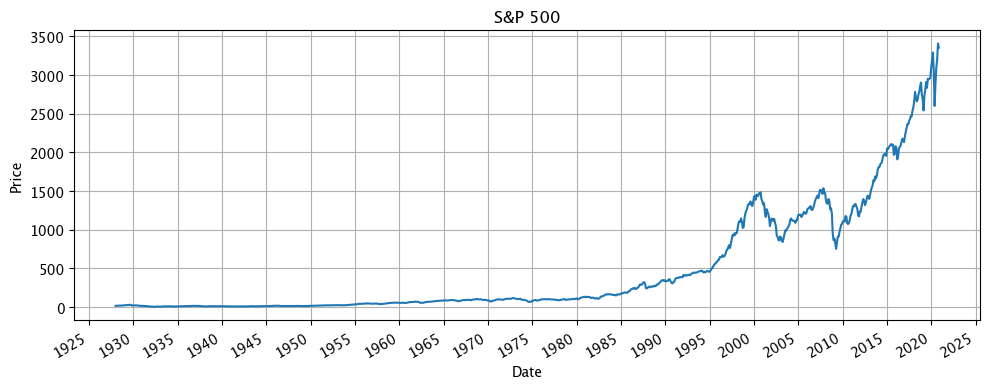

In [9]:
# Extract the close prices from the data
close_prices = features[:, close_price_idx]

# Reduce the close prices by taking the mean of each group of sequence length
close_prices = reduce_by_mean(close_prices, seq_len)

# Plot the reduced close prices
plot_data(close_prices, dates[0], dates[-1], x_freq=5)

### Data preprocessing

In [10]:
def build_sequences(features: np.ndarray, seq_length: int) -> tuple[Tensor, Tensor]:
    """
    Build sequences of data for training the model.
    
    Parameters:
    - features: np.ndarray, array of features to use for training
    - seq_length: int, length of the input sequences
    
    Returns:
    - tuple[Tensor, Tensor], tuple containing the input features and labels
    """
    
    # Create a list to hold the sequences and labels
    x, y = [], []
    
    # Iterate over the data to create sequences
    for i in range(seq_length, len(features)):
        # Append the sequence and target to the lists
        x.append(features[i-seq_length:i,:])
        y.append(features[i,:])

    # Convert the lists to numpy arrays
    return (
        Tensor(np.array(x, dtype=np.float32)),
        Tensor(np.array(y, dtype=np.float32))
    )

In [11]:
# Build sequences of input features and labels
features, targets = build_sequences(
    features = features,
    seq_length = seq_len
)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((features, targets), train_test_split_pct, shuffle=shuffle_data)
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split, shuffle=shuffle_data)

# Print the dataset information
print('Training set:', X_train.shape(), y_train.shape())
print('Validation set:', X_valid.shape(), y_valid.shape())
print('Testing set:', X_test.shape(), y_test.shape())

Training set: (14912, 24, 4) (14912, 4)
Validation set: (3728, 24, 4) (3728, 4)
Testing set: (4659, 24, 4) (4659, 4)


## Data normalization

In [12]:
def compute_normalization_stats(X: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the mean and standard deviation for each feature across all samples and all time steps.

    Parameters:
    - X (np.ndarray): Input tensor of shape (N, T, F)

    Returns:
    - mean (np.ndarray): Feature-wise mean, shape (F,)
    - std (np.ndarray): Feature-wise std, shape (F,)
    - min (np.ndarray): Feature-wise min, shape (F,)
    - max (np.ndarray): Feature-wise max, shape (F,)
    """
    
    # Compute the mean and standard deviation for each feature
    mean = X.mean(axis=(0, 1))
    std = X.std(axis=(0, 1))
    min = X.min(axis=(0, 1))
    max = X.max(axis=(0, 1))
    
    # Return the mean and standard deviation
    return mean, std, min, max

In [13]:
def min_max_normalization(X: np.ndarray, min: np.ndarray, max: np.ndarray) -> np.ndarray:
    """
    Applies min-max normalization using precomputed min and max.

    Parameters:
    - X (np.ndarray): Input tensor of shape (N, T, F)
    - min (np.ndarray): Feature-wise min, shape (F,)
    - max (np.ndarray): Feature-wise max, shape (F,)

    Returns:
    - np.ndarray: Normalized array of the same shape as X
    """
    
    # Normalize the data using the min and max
    norm_data = (X - min) / (max - min)
    
    # Return a new Tensor object with the normalized data
    return norm_data

def min_max_denormaliation(X: np.ndarray, min: np.ndarray, max: np.ndarray) -> np.ndarray:
    """
    Applies min-max denormalization using precomputed min and max.

    Parameters:
    - X (np.ndarray): Input tensor of shape (N, T, F)
    - min (np.ndarray): Feature-wise min, shape (F,)
    - max (np.ndarray): Feature-wise max, shape (F,)

    Returns:
    - np.ndarray: Denormalized array of the same shape as X
    """
    
    # Denormalize the data using the min and max
    denorm_data = X * (max - min) + min
    
    # Return a new Tensor object with the denormalized data
    return denorm_data

In [14]:
# Compute normalization statistics for the training data
mean, std, min, max = compute_normalization_stats(X_train.to_numpy())

# Normalize the features
X_train.data = min_max_normalization(X_train.to_numpy(), min, max)
X_valid.data = min_max_normalization(X_valid.to_numpy(), min, max)
X_test.data = min_max_normalization(X_test.to_numpy(), min, max)

# Normalize the targets
y_train.data = min_max_normalization(y_train.to_numpy(), min, max)
y_valid.data = min_max_normalization(y_valid.to_numpy(), min, max)
y_test.data = min_max_normalization(y_test.to_numpy(), min, max)

### Building the model

In [15]:
# Instantiating the model
model = SequentialAutoRegressive(
    name = "Stock prediction model",
    sequence_length = seq_len,
    modules = [
        layers.RNN(num_layers=4, num_units=48, dropout=0.1),
        layers.LayerNormalization(),
        layers.Dense(num_units=X_train.shape()[-1], activation=activations.ReLU()),
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [16]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    out = model(X_train[:batch_size])

In [17]:
# Display the model summary
model.summary(recursive=True)

Stock prediction model (SequentialAutoRegressive) [output_shape=(32, 4), params=16996]
└── stock_prediction_model.modules (ModuleList) [output_shape=(32, 4), params=16996]
    ├── module_list.0 (RNN) [output_shape=(32, 48), params=16704]
    │   └── rnn.dropout_layer (Dropout) [output_shape=(32, 48), params=0]
    ├── module_list.1 (LayerNormalization) [output_shape=(32, 48), params=96]
    └── module_list.2 (Dense) [output_shape=(32, 4), params=196]


### Training the model

In [18]:
history = model.fit(
    epochs = epochs,
    X_train = X_train, 
    y_train = y_train,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    optimizer = optimizer,
    batch_size = batch_size,
    shuffle = shuffle_data,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/50 --> loss: 0.014521 - mean absolute error: 0.05877 | Valid loss: 0.0007191 - Valid mean absolute error: 0.019338            
Epoch 2/50 --> loss: 0.0016201 - mean absolute error: 0.027075 | Valid loss: 0.00054899 - Valid mean absolute error: 0.01706             
Epoch 3/50 --> loss: 0.0010338 - mean absolute error: 0.022496 | Valid loss: 0.00039752 - Valid mean absolute error: 0.015073            
Epoch 4/50 --> loss: 0.00079868 - mean absolute error: 0.020059 | Valid loss: 0.00040003 - Valid mean absolute error: 0.014299            
Epoch 5/50 --> loss: 0.00064849 - mean absolute error: 0.018256 | Valid loss: 0.00033065 - Valid mean absolute error: 0.013618            
Epoch 6/50 --> loss: 0.00056704 - mean absolute error: 0.016886 | Valid loss: 0.00019938 - Valid mean absolute error: 0.0098135           
Epoch 7/50 --> loss: 0.00044469 - mean absolute error: 0.014696 | Valid loss: 0.00018751 - Valid mean absolute error: 0.010108            
Epoch 8/50 --> loss: 0.00040443 -

In [19]:
# Save the model
model.save(model_path)

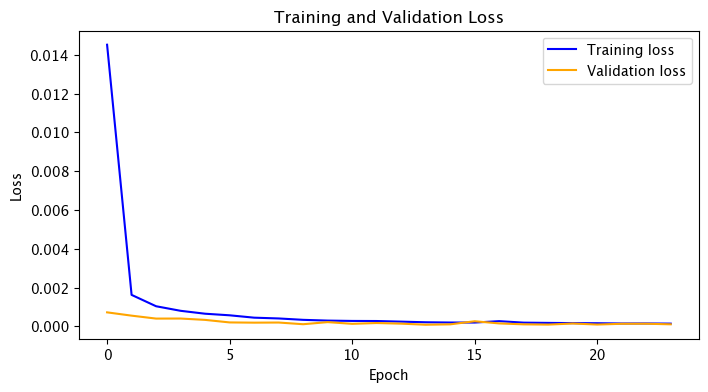

In [20]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch",
    ylabel = "Loss"
)

### Evaluation

In [21]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

In [22]:

# Denormalize the predictions and the true values
predictions = Tensor(min_max_denormaliation(predictions.to_numpy(), min, max))
y_test = Tensor(min_max_denormaliation(y_test.to_numpy(), min, max))

# Extract only the close prices from the predictions and the true values
close_prices_pred = predictions[:, close_price_idx]
close_prices_true = y_test[:, close_price_idx]

# Calculate the mean absolute error
mae = metrics.mean_absolute_error(close_prices_pred, close_prices_true)

# Print the mean absolute error
print("Mean Absolute Error:", mae.to_numpy())

Mean Absolute Error: 22.894793


### Inference

In [28]:

# Define the number of steps to generate and
# take a random sequence from the features set
num_generation_steps = 8
idx = np.random.randint(0, len(features.data) - 1)

# Select a random sequence from the features set and normalize it
input_seq = Tensor(min_max_normalization(features[idx:idx + 1].to_numpy(), min, max))

# Autoregressive generation
out_seq = model.autoregressive_generation(x=input_seq, num_steps=num_generation_steps)

# If the output is a generator, convert it to a list
out = model.concat_generation(out_seq) if not isinstance(out_seq, Tensor) else out_seq
    
# Concatenate the generated sequence with the input sequence and denormalize them
generated_sequence = Tensor(min_max_denormaliation(np.concatenate((input_seq.to_numpy(), out.to_numpy()), axis=1), min, max))

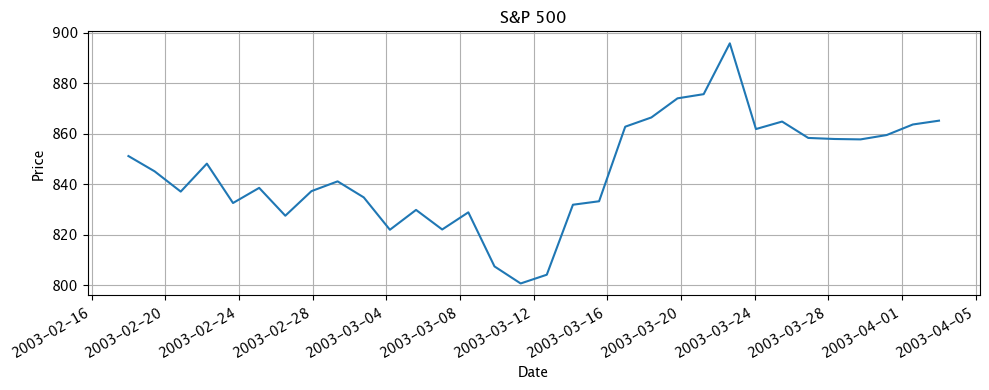

In [29]:
# Plot the generated sequence
plot_data(generated_sequence.to_numpy()[0, :, close_price_idx], dates[idx], dates[idx + seq_len + num_generation_steps], x_freq=4, freq_locator="day")